Include info from github about which number is which region and route etc

# Data Collection Script

The first step in the download is importing the necessary libraries that are used later in the script to handle downloading the file from the Himalayan database then unzipping the zip and reading the DBF files into csv to be used later in dataframes.

In [1]:
import logging
from pathlib import Path
import sys
import zipfile

from dbfread import DBF
import pandas as pd
import plotly.express as px
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

Logging is used to provide feedback regarding the download status and to assist with debugging.

The output folder is created to ensure there is somewhere for the downloaded file to be saved.

In [2]:
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
URL = "https://www.himalayandatabase.com/downloads/Himalayan%20Database.zip"
OUTPUT_DIR = Path("./himalayan_output")

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

A session with retries and browser-like headers was created to assist in the downloading process as the website provides errors when they are not provided.

In [3]:
session = requests.Session()
retries = Retry(
    total=5,
    backoff_factor=1.0,
    status_forcelist=(429, 500, 502, 503, 504),
    raise_on_status=False,
)
adapter = HTTPAdapter(max_retries=retries)
session.mount("https://", adapter)
session.mount("http://", adapter)
session.headers.update(
    {
        "User-Agent": "Mozilla/5.0 (compatible; HimalayanDBDownloader/1.0)",
        "Accept": "application/zip, application/octet-stream, */*",
        "Accept-Language": "en-US,en;q=0.9",
    }
)

The file is then downloaded into the output folder.

In [4]:
logging.info("Starting download: %s", URL)

zip_filename = OUTPUT_DIR / "Himalayan_Database.zip"
try:
    with session.get(URL, stream=True, timeout=30) as resp:
        resp.raise_for_status()
        with open(zip_filename, "wb") as out_f:
            for chunk in resp.iter_content(chunk_size=8192):
                if chunk:
                    out_f.write(chunk)
    tmp_path = zip_filename
except requests.RequestException as exc:
    logging.error("Download failed: %s", exc)
    sys.exit(2)

logging.info("Download complete, saved to %s", tmp_path)

INFO: Starting download: https://www.himalayandatabase.com/downloads/Himalayan%20Database.zip
INFO: Download complete, saved to himalayan_output\Himalayan_Database.zip


The downloaded ZIP file contains multiple DBF and FPT files which are then extracted and converted into the csv files that will be worked on later 

In [5]:
temp_extract_dir = OUTPUT_DIR
logging.info("Extracting ZIP into output directory: %s", temp_extract_dir)

try:
    with zipfile.ZipFile(tmp_path, "r") as zf:
        all_members = zf.namelist()
        dbf_names = [n for n in all_members if n.lower().endswith(".dbf")]
        if not dbf_names:
            logging.error("No .dbf files found in the ZIP archive.")
            sys.exit(3)

        members_map = {n.lower(): n for n in all_members}

        for dbf_member in dbf_names:
            base_lower = dbf_member.lower()[:-4]
            memo_candidates = []
            for memo_ext in (".fpt", ".dbt"):
                candidate_lower = base_lower + memo_ext
                if candidate_lower in members_map:
                    memo_candidates.append(members_map[candidate_lower])

            to_extract = [dbf_member] + memo_candidates
            extracted_paths = []
            for member in to_extract:
                try:
                    extracted_path = Path(zf.extract(member, path=str(temp_extract_dir)))
                    extracted_paths.append(extracted_path)
                except Exception as exc:
                    logging.warning("Failed to extract %s: %s", member, exc)

            logging.info("Found DBF: %s; memo files: %s", dbf_member, [p.name for p in extracted_paths if p.suffix.lower() in (".fpt", ".dbt")])

            try:
                table = DBF(str(temp_extract_dir / dbf_member), load=True)
                df = pd.DataFrame(list(table))
                csv_name = OUTPUT_DIR / (Path(dbf_member).stem + ".csv")
                df.to_csv(csv_name, index=False)
                logging.info(
                    "Wrote CSV: %s (rows=%d, cols=%d)",
                    csv_name,
                    len(df),
                    len(df.columns),
                )
            except Exception as exc:
                if "missing memo" in str(exc).lower() or "missing memo file" in str(exc).lower():
                    logging.error(
                        "Failed to convert %s to CSV: %s. The DBF requires an accompanying memo file (.fpt or .dbt).",
                        dbf_member,
                        exc,
                    )
                else:
                    logging.error("Failed to convert %s to CSV: %s", dbf_member, exc)
finally:
    pass

logging.info(
    "All done. CSV files and extracted DBFs are in %s; ZIP saved as %s",
    OUTPUT_DIR,
    zip_filename.name,
)


INFO: Extracting ZIP into output directory: himalayan_output
INFO: Found DBF: HIMDATA/exped.DBF; memo files: ['exped.FPT']
INFO: Wrote CSV: himalayan_output\exped.csv (rows=11695, cols=66)
INFO: Found DBF: HIMDATA/filters.DBF; memo files: ['FILTERS.FPT']
INFO: Wrote CSV: himalayan_output\filters.csv (rows=0, cols=0)
INFO: Found DBF: HIMDATA/members.DBF; memo files: ['members.FPT']
INFO: Wrote CSV: himalayan_output\members.csv (rows=92767, cols=78)
INFO: Found DBF: HIMDATA/peaks.DBF; memo files: ['peaks.FPT']
INFO: Wrote CSV: himalayan_output\peaks.csv (rows=490, cols=25)
INFO: Found DBF: HIMDATA/refer.DBF; memo files: ['refer.FPT']
INFO: Wrote CSV: himalayan_output\refer.csv (rows=16277, cols=13)
INFO: Found DBF: HIMDATA/SETUP.DBF; memo files: []
INFO: Wrote CSV: himalayan_output\SETUP.csv (rows=1, cols=6)
INFO: All done. CSV files and extracted DBFs are in himalayan_output; ZIP saved as Himalayan_Database.zip


The output csv files are then read into dataframes to ensure the process has been completed successfully.

In [6]:
expeddf = pd.read_csv("himalayan_output/exped.csv", low_memory=False)
peaksdf = pd.read_csv("himalayan_output/peaks.csv", low_memory=False)

In [7]:
expeddf

,EXPID,PEAKID,YEAR,SEASON,HOST,ROUTE1,ROUTE2,ROUTE3,ROUTE4,NATION,...,ACCIDENTS,ACHIEVMENT,AGENCY,COMRTE,STDRTE,PRIMRTE,PRIMMEM,PRIMREF,PRIMID,CHKSUM
0,ANN260101,ANN2,1960,1,1,NW Ridge-W Ridge,NaN,NaN,NaN,UK,...,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,2442047
1,ANN269301,ANN2,1969,3,1,NW Ridge-W Ridge,NaN,NaN,NaN,Yugoslavia,...,Draslar frostbitten hands and feet,NaN,NaN,NaN,NaN,False,False,NaN,NaN,2445501
2,ANN273101,ANN2,1973,1,1,W Ridge-N Face,NaN,NaN,NaN,Japan,...,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,2446797
3,ANN278301,ANN2,1978,3,1,N Face-W Ridge,NaN,NaN,NaN,UK,...,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,2448822
4,ANN279301,ANN2,1979,3,1,N Face-W Ridge,NW Ridge of A-IV,NaN,NaN,UK,...,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,2449204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11690,SWEL25101,SWEL,2025,1,1,SE Ridge,NaN,NaN,NaN,France,...,NaN,NaN,Ethic Himalaya Treks,False,False,False,False,False,NaN,2464999
11691,TENR17301,TENR,2017,3,1,NW Face,NaN,NaN,NaN,Japan,...,NaN,NaN,Cosmo Treks,False,False,False,False,False,NaN,4222
11692,YASA24302,YASA,2024,3,1,NaN,NaN,NaN,NaN,Thailand,...,NaN,NaN,NaN,False,False,False,False,False,NaN,2464966
11693,YLNG25101,YLNG,2025,1,1,NaN,NaN,NaN,NaN,Slovakia,...,NaN,NaN,Cho Oyu Trekking,False,False,True,False,True,KABR25101,4320


In [8]:
peaksdf

,PEAKID,PKNAME,PKNAME2,LOCATION,HEIGHTM,HEIGHTF,HIMAL,REGION,OPEN,UNLISTED,...,PEAKMEMO,PYEAR,PSEASON,PEXPID,PSMTDATE,PCOUNTRY,PSUMMITERS,PSMTNOTE,REFERMEMO,PHOTOMEMO
0,AMAD,Ama Dablam,Amai Dablang,Khumbu Himal,6814,22356,12,2,True,False,...,"Other map altitudes:\r\n 6814m - HMG-MT, HMG...",1961.0,1,AMAD61101,Mar 13,"New Zealand, USA, UK","Mike Gill, Wally Romanes, Barry Bishop, Michae...",NaN,NaN,W Face (High 126:5 May 1993)\r\nSE Face (High ...
1,AMPG,Amphu Gyabjen,Amphu Gyabien,Khumbu Himal (N of Ama Dablam),5630,18471,12,2,True,False,...,"Other map altitudes:\r\n 5630m - HMG-Finn, N...",1953.0,1,AMPG53101,Apr 11,UK,"John Hunt, Tom Bourdillon",NaN,NaN,NaN
2,ANN1,Annapurna I,NaN,Annapurna Himal,8091,26545,1,5,True,False,...,"Other map altitudes:\r\n 8091m - HMG-MT, HMG...",1950.0,1,ANN150101,Jun 03,France,"Maurice Herzog, Louis Lachenal",NaN,Dyhrenfurth history 1950-1977 (MM 58:44-47 Nov...,S Face (High 122:3 Jan 1993) (Beghin accident)...
3,ANN2,Annapurna II,NaN,Annapurna Himal,7937,26040,1,5,True,False,...,"Other map altitudes:\r\n 7937m - HMG-MT, HMG...",1960.0,1,ANN260101,May 17,"UK, Nepal","Richard Grant, Chris Bonington, Ang Nyima Sherpa",NaN,Dyhrenfurth history 1960-1976 (MM 51:36-37 Sep...,N Face (MM 51:36 Sep 1976)
4,ANN3,Annapurna III,NaN,Annapurna Himal,7555,24787,1,5,True,False,...,"Other map altitudes:\r\n 7555m - HMG-MT, HMG...",1961.0,1,ANN361101,May 06,India,"Mohan S. Kohli, Sonam Gyatso, Sonam Girmi",NaN,NaN,S Side (MM 125:11 Jan 1989)\r\nSW Face (MM 71:...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,MAHA,Mahalanagur,NaN,Rolwaling Himal (W of Nangpa La on Tibetan bor...,6445,21145,19,2,True,False,...,"Other map altitudes:\r\n 6445m - HMG-MT, HMG...",NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486,CHWE,Chaw East,NaN,Ohmi Kangri Himal (ESE of Chaw Peak on Tibetan...,6557,21512,6,1,True,False,...,"Other map altitudes:\r\n 6557m - HMG-MT, HMG...",NaN,0,NaN,NaN,NaN,Unclimbed,NaN,NaN,NaN
487,PTHN,Pathibhara Northeast,Pathibhara East,Jongsang Himal (NE of Sphinx on Indian border),6857,22497,7,1,True,False,...,Other map altitudes:\r\n 6852m - Japan MMW\r...,NaN,0,NaN,NaN,NaN,Unclimbed,NaN,NaN,NaN
488,PTHS,Pathibhara Southeast,NaN,Jongsang Himal (SE of Pyramid Peak on Indian b...,6868,22533,7,1,True,False,...,Other map altitudes:\r\n 6650m - Japan MMW\r...,NaN,0,NaN,NaN,NaN,Unclimbed,NaN,NaN,NaN


A little bit of analysis is completed to ensure that the files were downloaded and extracted properly that they can be used on further steps.

In [9]:
expeddf["YEAR"]

0        1960
1        1969
2        1973
3        1978
4        1979
         ... 
11690    2025
11691    2017
11692    2024
11693    2025
11694    2024
Name: YEAR, Length: 11695, dtype: int64

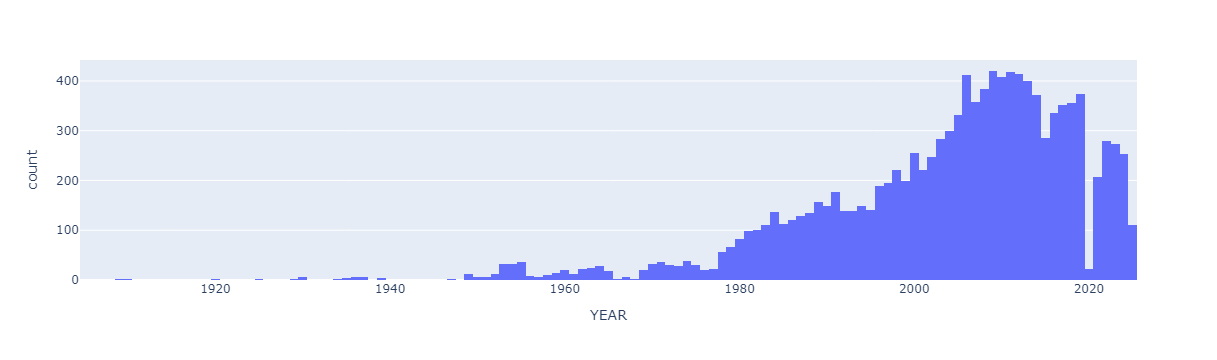

In [10]:
fig = px.histogram(expeddf, x="YEAR")
fig.show()

To ensure that our peak specific analysis can be completed the peak name is used to filter the output expedition dataframe.

In [11]:
peaknamedf = peaksdf.loc[peaksdf.PKNAME.str.contains("EVEREST", case=False)]
peaknamedf

,PEAKID,PKNAME,PKNAME2,LOCATION,HEIGHTM,HEIGHTF,HIMAL,REGION,OPEN,UNLISTED,...,PEAKMEMO,PYEAR,PSEASON,PEXPID,PSMTDATE,PCOUNTRY,PSUMMITERS,PSMTNOTE,REFERMEMO,PHOTOMEMO
42,EVER,Everest,"Sagarmatha, Chomolungma, Qomolungma",Khumbu Himal,8849,29032,12,2,True,False,...,Other map altitudes:\r\n 8850m - National Ge...,1953.0,1,EVER53101,May 29,"New Zealand, India","Edmund Hillary, Tenzing Norgay Sherpa",NaN,Dyhrenfurth history 1921-1980 (MM 76:30-39 Nov...,"NE Ridge, N Ridge, N Face (High 167:70 Oct 199..."


In [12]:
evereexpeddf = expeddf.loc[expeddf.PEAKID.str.contains("EVER",case=True)]
evereexpeddf

,EXPID,PEAKID,YEAR,SEASON,HOST,ROUTE1,ROUTE2,ROUTE3,ROUTE4,NATION,...,ACCIDENTS,ACHIEVMENT,AGENCY,COMRTE,STDRTE,PRIMRTE,PRIMMEM,PRIMREF,PRIMID,CHKSUM
106,EVER88401,EVER,1988,4,1,S Col-SE Ridge,NaN,NaN,NaN,Belgium,...,"Dewaele exhausted, shocked, needed O2 and was ...",NaN,Mountain Travel,True,True,False,False,NaN,NaN,2449641
108,EVER88402,EVER,1988,4,1,SW Face (Bonington rte),NaN,NaN,NaN,S Korea,...,NaN,NaN,NaN,False,NaN,False,False,NaN,NaN,2449660
382,EVER89306,EVER,1989,3,2,N Col-N Face (Great Couloir),NaN,NaN,NaN,USA,...,NaN,NaN,NaN,False,False,False,False,NaN,NaN,2449938
383,EVER89310,EVER,1989,3,2,N Face (Japanese Couloir),NaN,NaN,NaN,Italy,...,NaN,NaN,Trekking International,False,NaN,False,False,NaN,NaN,2449919
384,EVER89305,EVER,1989,3,2,N Col-N Face (Messner Couloir),NaN,NaN,NaN,Switzerland,...,NaN,NaN,Sherpa Society,False,False,False,False,NaN,NaN,2449919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11641,EVER25140,EVER,2025,1,2,N Col-NE Ridge,NaN,NaN,NaN,USA,...,NaN,NaN,Himalaya Vision,True,True,False,False,False,NaN,2464063
11642,EVER25141,EVER,2025,1,2,N Col-NE Ridge,NaN,NaN,NaN,Switzerland,...,NaN,NaN,Himalaya Vision,True,True,False,False,False,NaN,2464060
11643,EVER25142,EVER,2025,1,2,N Col-NE Ridge,NaN,NaN,NaN,Lithuania,...,NaN,NaN,Climbalaya,True,True,False,False,False,NaN,2464055
11644,EVER25143,EVER,2025,1,2,N Col-NE Ridge,NaN,NaN,NaN,Nepal,...,NaN,NaN,Imagine Nepal,True,True,False,False,False,NaN,2464059


In [13]:
fig = px.histogram(evereexpeddf, x="YEAR")
fig.show()

In [14]:
expeddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11695 entries, 0 to 11694
Data columns (total 66 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   EXPID       11695 non-null  object 
 1   PEAKID      11695 non-null  object 
 2   YEAR        11695 non-null  int64  
 3   SEASON      11695 non-null  int64  
 4   HOST        11695 non-null  int64  
 5   ROUTE1      11535 non-null  object 
 6   ROUTE2      370 non-null    object 
 7   ROUTE3      30 non-null     object 
 8   ROUTE4      5 non-null      object 
 9   NATION      11695 non-null  object 
 10  LEADERS     11671 non-null  object 
 11  SPONSOR     10876 non-null  object 
 12  SUCCESS1    11695 non-null  bool   
 13  SUCCESS2    11695 non-null  bool   
 14  SUCCESS3    11695 non-null  bool   
 15  SUCCESS4    11695 non-null  bool   
 16  ASCENT1     2791 non-null   object 
 17  ASCENT2     101 non-null    object 
 18  ASCENT3     11 non-null     object 
 19  ASCENT4     4 non-null   

Having reviewed the data, specifically looking at the seasons, location of the mountains and the Term Reasons, particulary in Term Reaons as 1, 2 and 3 where all successes of various degrees (1 = Success main peak, 2= Success subpeak foresummit and 3 = Success (claimed)), the decision was made to use naturual language and tidy the data. 

This was also done within the github tidy Tuesday data however the code was written in R. This code was then refactored and tested and added into the 2_Data_Collection file for expeddf. 

Having reviewed the result peaksdf was also update in a similar fashion as per the Tidy Tuesday readme (see below).

The original readme is here: https://github.com/rfordatascience/tidytuesday/blob/main/data/2025/2025-01-21/readme.md



In [31]:
#import pandas as pd

#expeddf = pd.read_csv("himalayan_output/exped.csv", low_memory=False)
# start from the expeddf Dataframe
expeddf_tidy = expeddf.copy()




In [16]:
#SEASON
expeddf_tidy["SEASON"] = (expeddf_tidy["SEASON"].map({
    0:"Unknown",
    1:"Spring",
    2:"Autumn",
    3:"Winter",
}))

In [17]:
expeddf["SEASON"]

0        1
1        3
2        1
3        3
4        3
        ..
11690    1
11691    3
11692    3
11693    1
11694    4
Name: SEASON, Length: 11695, dtype: int64

In [18]:
expeddf_tidy["SEASON"]

0        Spring
1        Winter
2        Spring
3        Winter
4        Winter
          ...  
11690    Spring
11691    Winter
11692    Winter
11693    Spring
11694       NaN
Name: SEASON, Length: 11695, dtype: object

In [19]:
#HOST
expeddf_tidy["HOST"] = (expeddf_tidy["HOST"].map({
    0:"Unknown",
    1:"Nepal",
    2:"China",
    3: "India",
}))



In [20]:
expeddf_tidy["HOST"]

0        Nepal
1        Nepal
2        Nepal
3        Nepal
4        Nepal
         ...  
11690    Nepal
11691    Nepal
11692    Nepal
11693    Nepal
11694    Nepal
Name: HOST, Length: 11695, dtype: object

In [21]:
expeddf_tidy["HOST"].value_counts()

HOST
Nepal      9362
China      2262
India        69
Unknown       2
Name: count, dtype: int64

In [22]:
print(expeddf["TERMREASON"].dtype)


int64


In [23]:
expeddf["TERMREASON"].value_counts()

TERMREASON
1     6559
4     1411
5     1180
7      495
10     454
14     332
6      303
12     255
8      225
2      147
0      136
9       98
11      66
3       22
13      12
Name: count, dtype: int64

In [24]:
#TERMREASON
expeddf_tidy["TERMREASON"] = pd.to_numeric(
    expeddf_tidy["TERMREASON"], errors="coerce"
) 

expeddf_tidy["TERMREASON"] = (expeddf_tidy["TERMREASON"].astype(int).map({
    0:"Unknown",
    1:"Success (main peak)",
    2:"Success (subpeak, foresummit)",
    3:"Success (claimed)",
    4:"Bad weather (storms, high winds)",
    5:"Bad conditions (deep snow, avalanching, falling ice, or rock)",
    6:"Accident (death or serious injury)",
    7:"Illness, AMS, exhaustion, or frostbite",
    8:"Lack (or loss) of supplies, support or equipment",
    9:"Lack of time",
    10:"Route technically too difficult, lack of experience, strength, or motivation",
    11:"Did not reach base camp",
    12:"Did not attempt climb",
    13:"Attempt rumored",
    14:"Other",
}))

In [25]:
expeddf_tidy["TERMREASON"]

0                                      Success (main peak)
1                                      Success (main peak)
2                                      Success (main peak)
3                         Bad weather (storms, high winds)
4                         Bad weather (storms, high winds)
                               ...                        
11690    Bad conditions (deep snow, avalanching, fallin...
11691    Bad conditions (deep snow, avalanching, fallin...
11692                                  Success (main peak)
11693                                Did not attempt climb
11694                     Bad weather (storms, high winds)
Name: TERMREASON, Length: 11695, dtype: object

In [26]:
print(expeddf_tidy["TERMREASON"].value_counts())

TERMREASON
Success (main peak)                                                             6559
Bad weather (storms, high winds)                                                1411
Bad conditions (deep snow, avalanching, falling ice, or rock)                   1180
Illness, AMS, exhaustion, or frostbite                                           495
Route technically too difficult, lack of experience, strength, or motivation     454
Other                                                                            332
Accident (death or serious injury)                                               303
Did not attempt climb                                                            255
Lack (or loss) of supplies, support or equipment                                 225
Success (subpeak, foresummit)                                                    147
Unknown                                                                          136
Lack of time                                          

In [27]:
from pathlib import Path
TIDY_DIR = Path("./himalayan_tidy")

# Create output directory
TIDY_DIR.mkdir(parents=True, exist_ok=True)

In [28]:
expeddf_tidy.to_csv("./himalayan_tidy/expeddf_tidy.csv", index=False)